# Defining Gas Inflow

Prepared by: Benoit Côté (bcote@uvic.ca)

This notebook shows how to control and define the gas inflow rate in <a href="http://adsabs.harvard.edu/abs/2017arXiv171006442C">OMEGA+</a>.  It represents the mass transfer from the circumgalactic medium (gas reservoir surrounding the galaxy) into the central galaxy (which is modeled with <a href="http://adsabs.harvard.edu/abs/2017ApJ...835..128C">OMEGA</a>).

With OMEGA+, you might be interested in using the <a href="https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Fast_chem_evol.ipynb">fast NuPyCEE</a> option, and the <a href="https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb">timestep size management</a> option.

#### Different inflow options

- `1:` Exponential equations
- `2:` Constant inflow timescale
- `3:` Inflow timescale proportional to free-fall timescale
- `4:` Input array

In [1]:
# Import python modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Import the OMEGA+ module
from JINAPyCEE import omega_plus

## 1. Exponential Inflow Law

The first option is to input an exponential inflow equation in the following form.

$$ \dot{M}_\mathrm{inflow}(t)=N_\mathrm{norm}\mathrm{exp}\left(\frac{-(t-t_0)}{\tau}\right)$$

The code will then use the equation to calculate the inflow rate, regardless of the amount of gas inside the circumgalactic medium.  OMEGA+ can combine an arbitrary number of exponential equations, and can thus reproduce the two-infall model of <a href="http://adsabs.harvard.edu/abs/1997ApJ...477..765C">Chiappini et al. (1997)</a>. The key parameter is the following.

**`exp_infall[ number of exp equations ][ i ]`**

- `i = 0:`  $N_\mathrm{norm}$
- `i = 1:`  $t_0$
- `i = 0:`  $\tau$

In [2]:
# Define the initial mass of gas in the galaxy [Msun]
mgal = 1.0

# Define the dark matter halo mass [Msun]
# This will set the gas mass in the circumgalactic medium
m_DM_0 = 1.0e12

# Set the star formation efficiency
sfe = 0.01

# Number of timesteps (see also timestep management link above)
special_timesteps = 90

# Set the common arguments for the upcoming OMEGA+ runs
kwargs = {"mgal":mgal, "m_DM_0":m_DM_0, "sfe":sfe, "special_timesteps":special_timesteps}

In [3]:
# Run OMEGA+ with a single exponential law
exp_infall = [[10, 1.0e9, 7.0e9]]
op1_1exp = omega_plus.omega_plus(exp_infall=exp_infall, **kwargs)

# Run OMEGA+ with a double exponential law
exp_infall = [[20, 0.0, 2.0e9], [10, 1.0e9, 7.0e9]]
op1_2exp = omega_plus.omega_plus(exp_infall=exp_infall, **kwargs)

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.39s
   OMEGA+ run completed - Run time: 1.39s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.34s
   OMEGA+ run completed - Run time: 1.34s


<IPython.core.display.Javascript object>


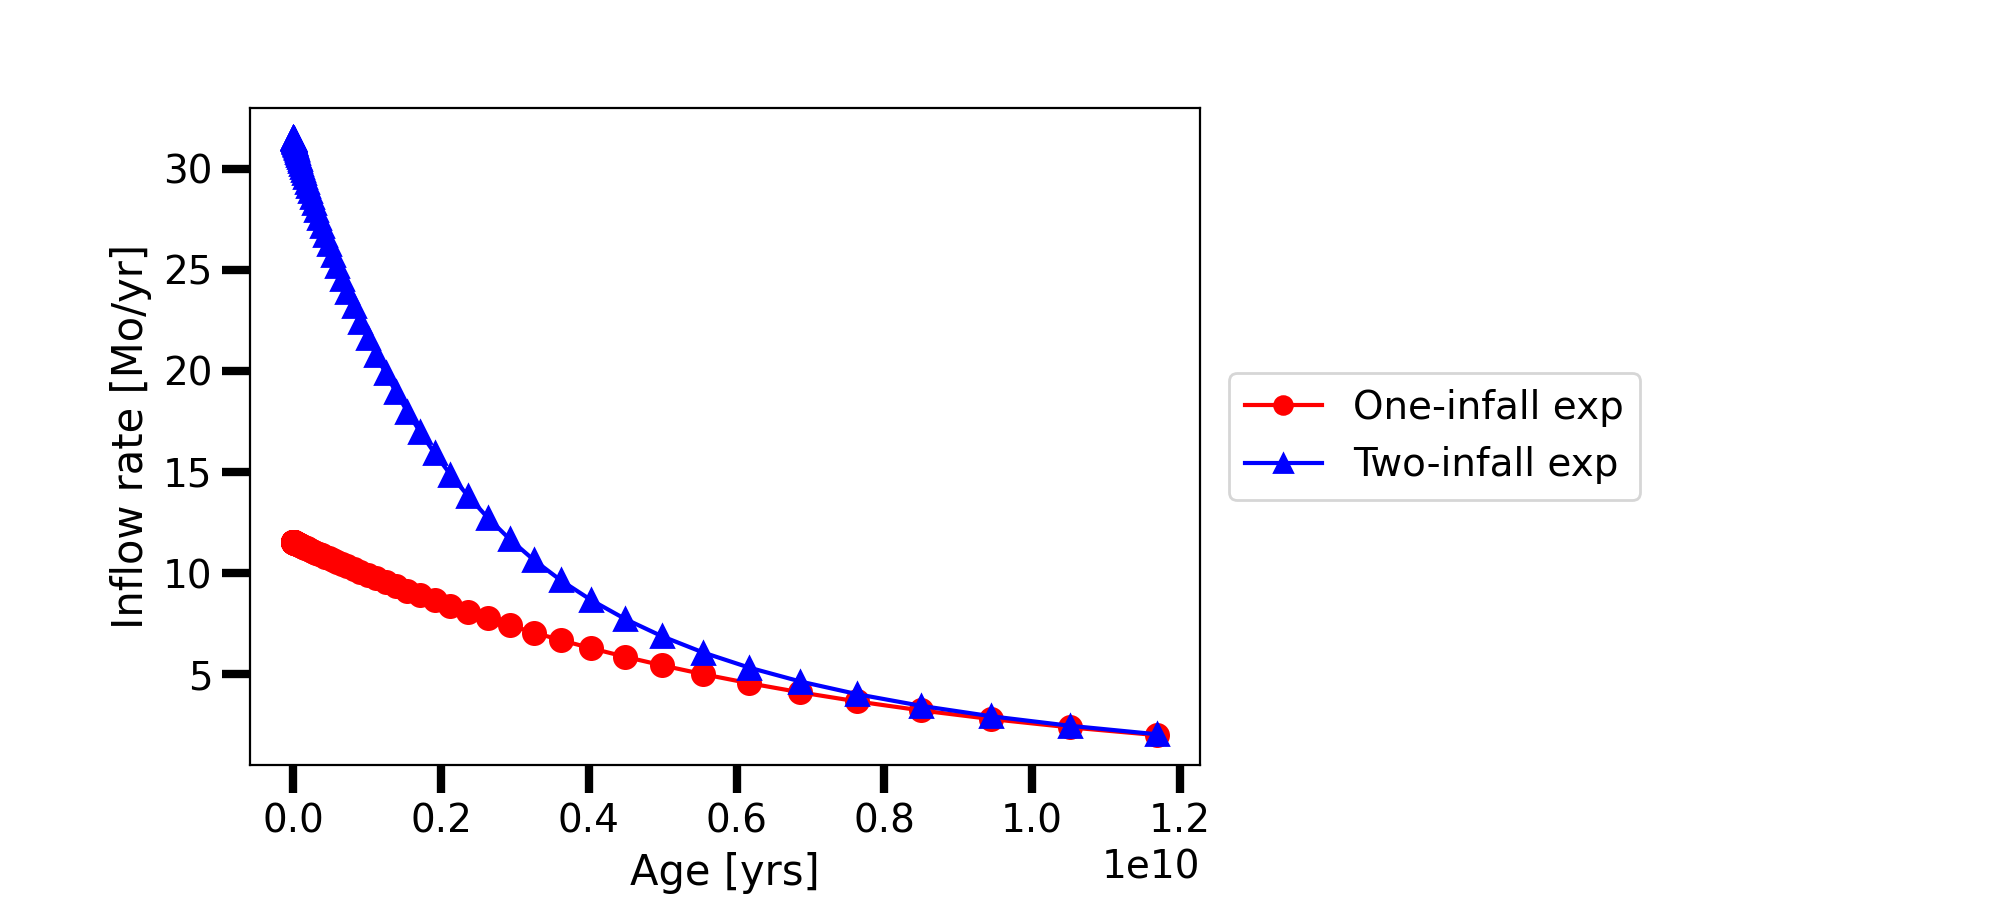

In [5]:
# Plot the inflow history
# Note: the OMEGA instance is the "inner"
%matplotlib nbagg
op1_1exp.inner.plot_inflow_rate(color='r', marker="o", label='One-infall exp')
op1_2exp.inner.plot_inflow_rate(color='b', marker="^", label='Two-infall exp')

<IPython.core.display.Javascript object>


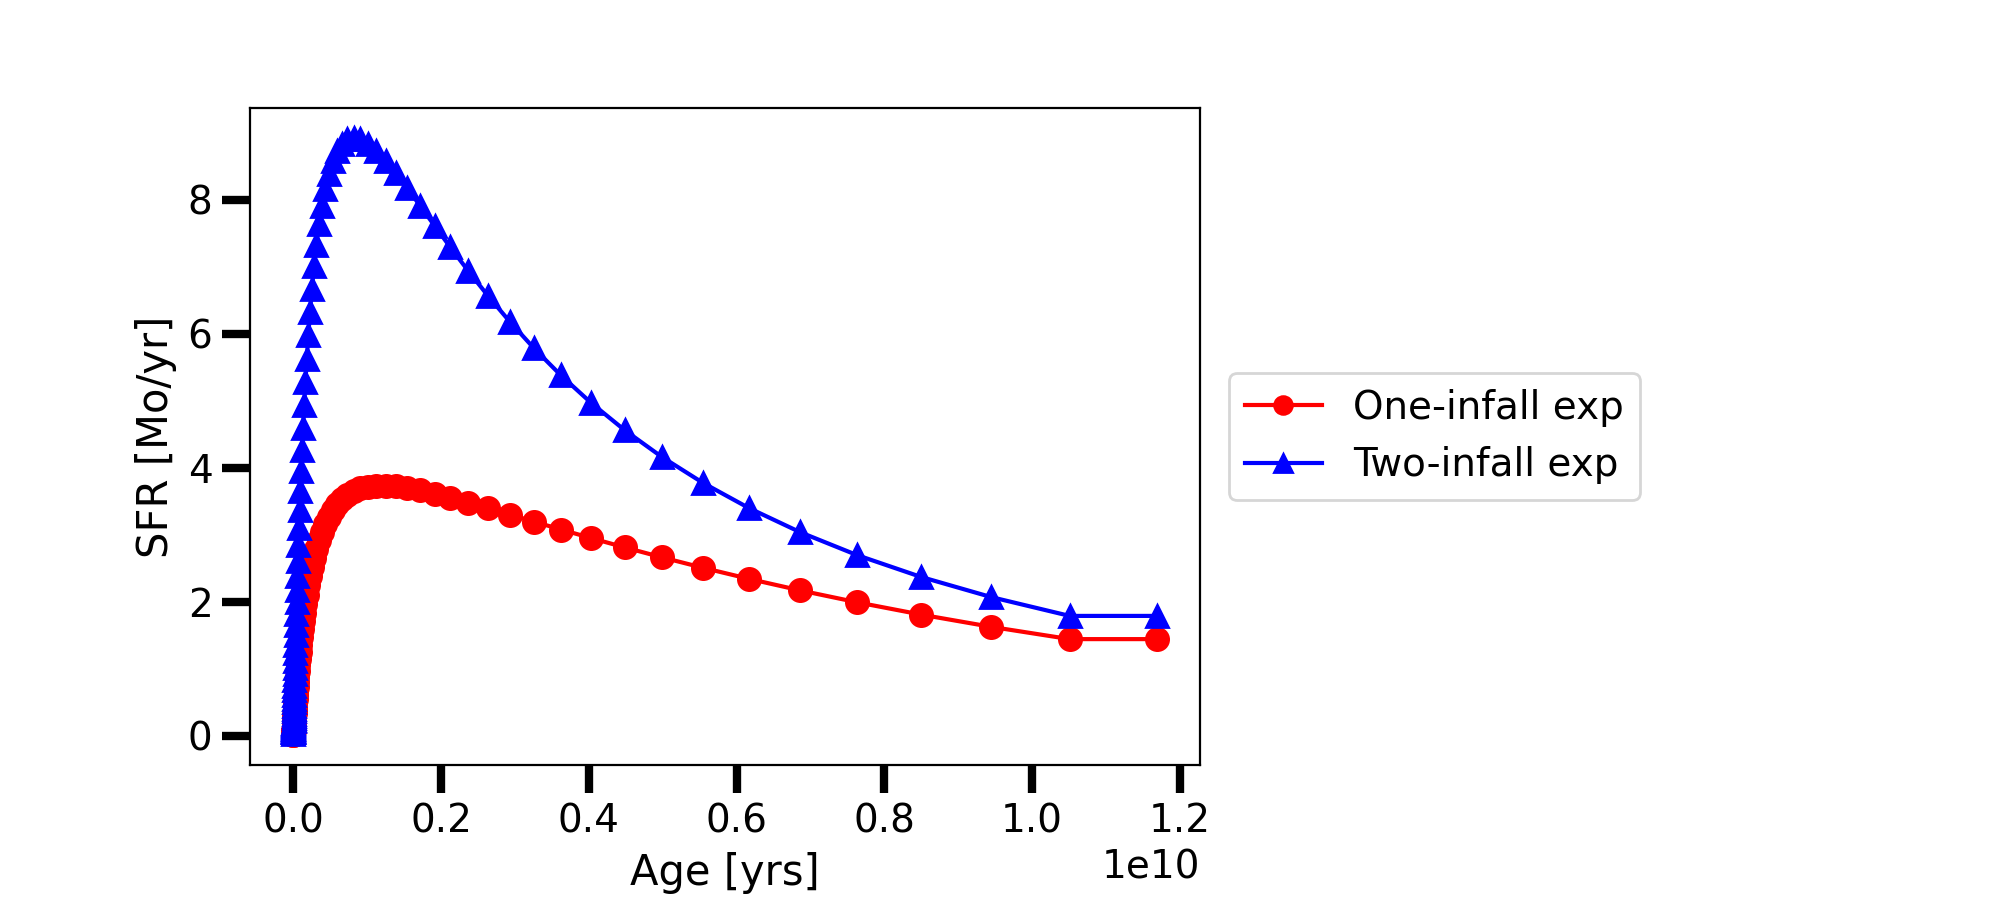

In [6]:
# Plot the star formation history
%matplotlib nbagg
op1_1exp.inner.plot_star_formation_rate(color='r', marker="o", label='One-infall exp')
op1_2exp.inner.plot_star_formation_rate(color='b', marker="^", label='Two-infall exp')

## 2. Constant Inflow Timescale

This option fixes the inflow timescale ($\tau$) to a constant value.  The inflow rate will thus be defined by the mass of gas inside the circumgalactic medium ($M_\mathrm{CGM}$).

$$ \dot{M}_\mathrm{inflow}(t) = \frac{M_\mathrm{CGM}(t)}{\tau}$$

**Note**: The mass of the circumgalactic medium is also affected by the amount of mass injected by galactic outflows.

In [7]:
# Run OMEGA+ with different inflow timescales
op2_5e8 = omega_plus.omega_plus(t_inflow=5.0e8, **kwargs)
op2_1e9 = omega_plus.omega_plus(t_inflow=1.0e9, **kwargs)
op2_2e9 = omega_plus.omega_plus(t_inflow=2.0e9, **kwargs)

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.43s
   OMEGA+ run completed - Run time: 1.43s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.36s
   OMEGA+ run completed - Run time: 1.36s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.42s
   OMEGA+ run completed - Run time: 1.42s


<IPython.core.display.Javascript object>


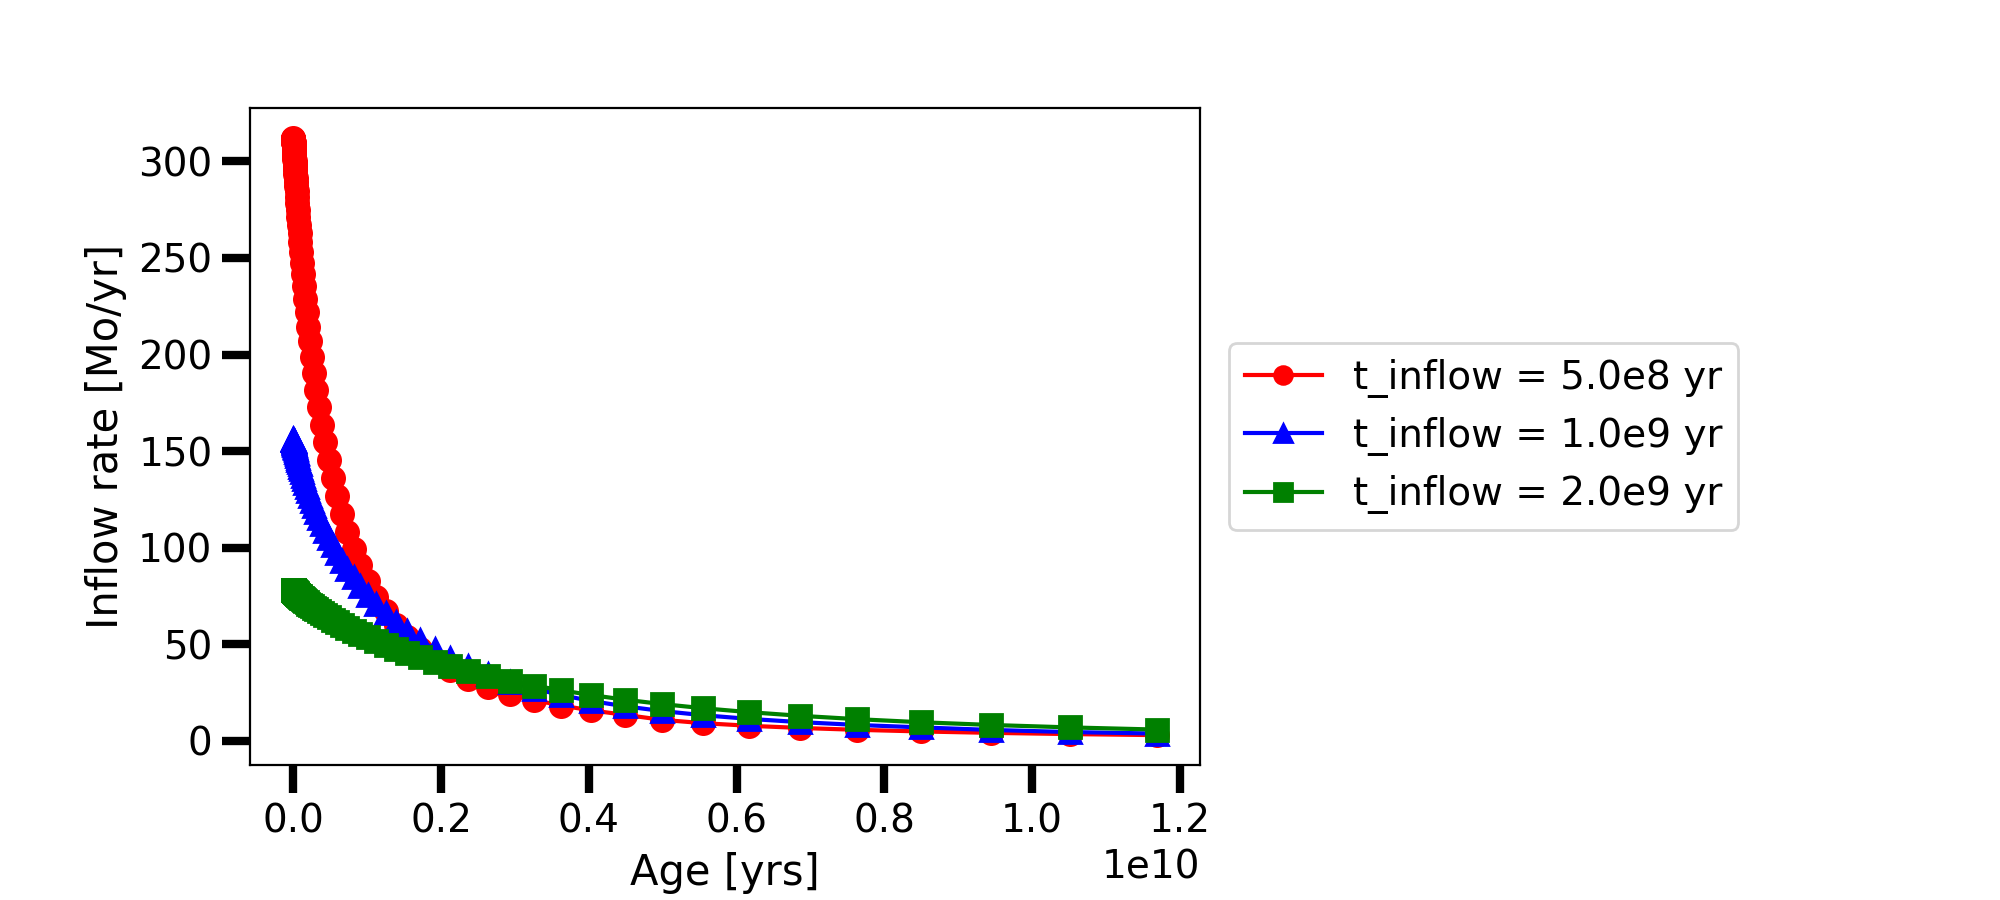

In [8]:
# Plot the inflow history
%matplotlib nbagg
op2_5e8.inner.plot_inflow_rate(color='r', marker="o", label='t_inflow = 5.0e8 yr')
op2_1e9.inner.plot_inflow_rate(color='b', marker="^", label='t_inflow = 1.0e9 yr')
op2_2e9.inner.plot_inflow_rate(color='g', marker="s", label='t_inflow = 2.0e9 yr')

<IPython.core.display.Javascript object>


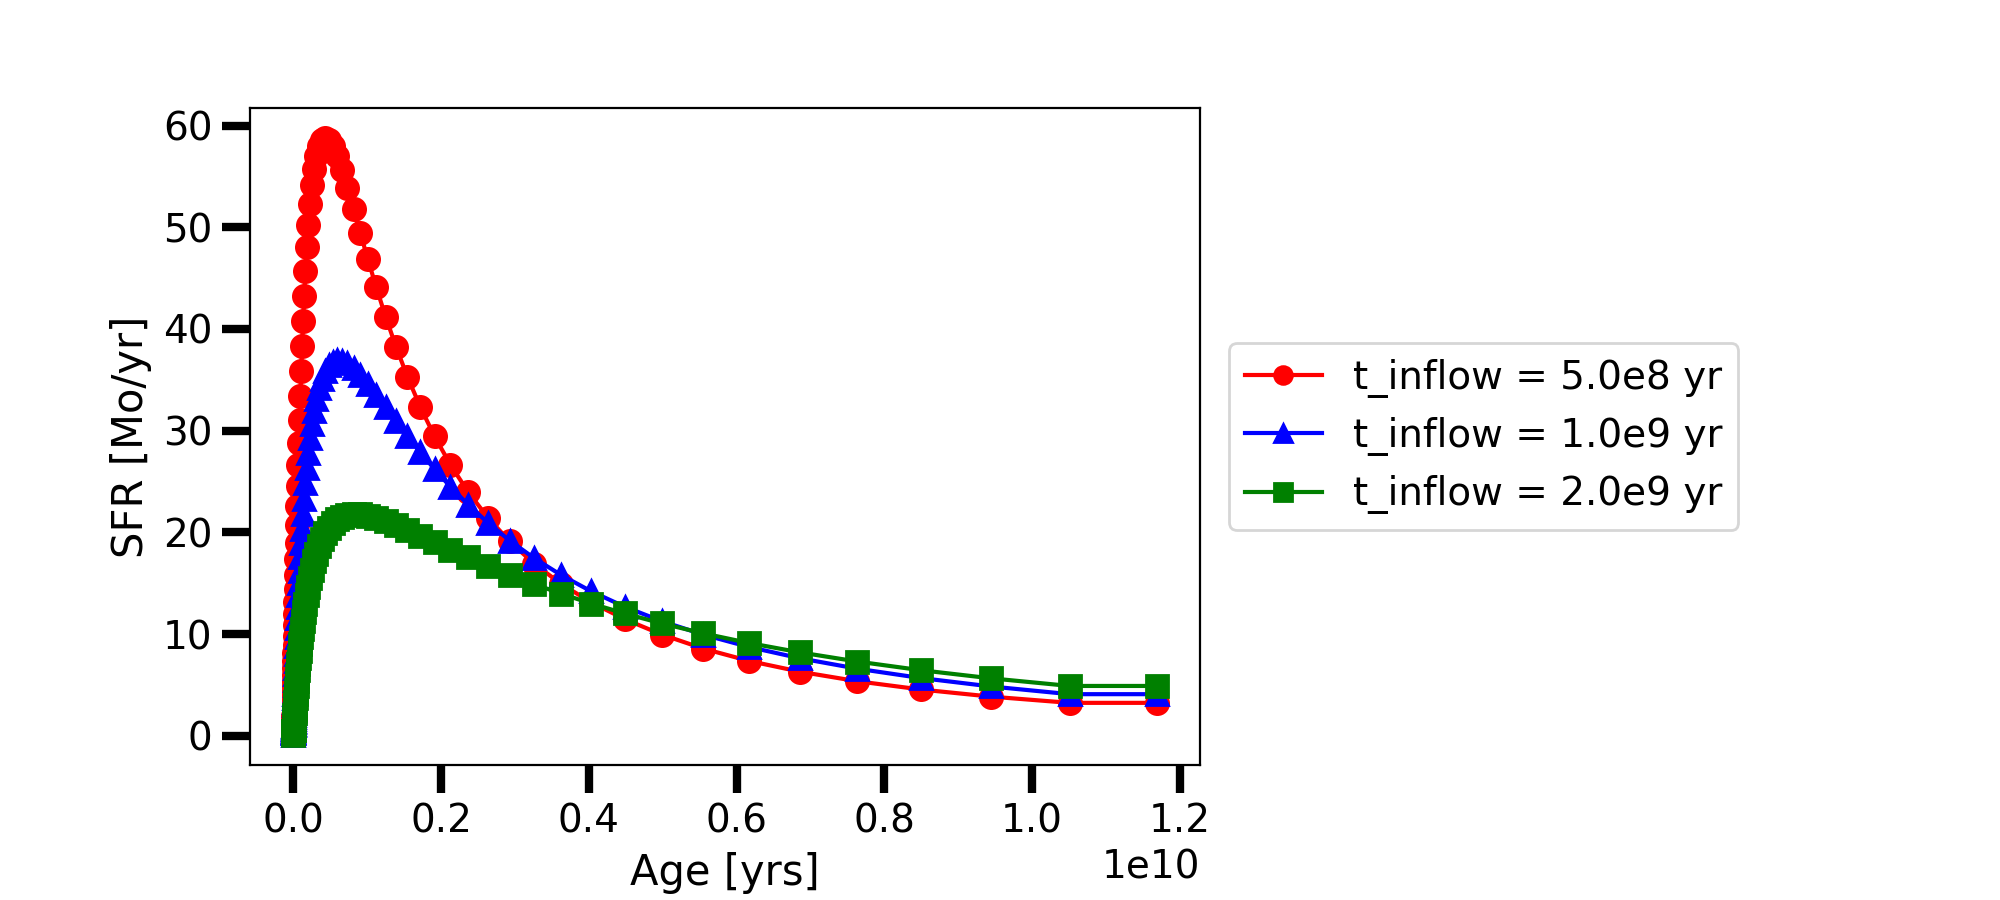

In [9]:
# Plot the star formation history
%matplotlib nbagg
op2_5e8.inner.plot_star_formation_rate(color='r', marker="o", label='t_inflow = 5.0e8 yr')
op2_1e9.inner.plot_star_formation_rate(color='b', marker="^", label='t_inflow = 1.0e9 yr')
op2_2e9.inner.plot_star_formation_rate(color='g', marker="s", label='t_inflow = 2.0e9 yr')

## 3. Inflow Based on Free-Fall Timescale

This option ties the inflow timescale to the free-fall timescale of the dark matter halo, which depends on redshift.

$$ \tau(t) = f_\mathrm{ff}\times t_\mathrm{ff}(t)$$

$$ \dot{M}_\mathrm{inflow}(t) = \frac{M_\mathrm{CGM}(t)}{\tau(t)}$$

**Note**: When $t_\mathrm{ff}=1$, this refers to the fast-cooling mode used in semi-analytic models (e.g., <a href="http://adsabs.harvard.edu/abs/2001MNRAS.328..726S">Springel et al. 2001</a>; <a href="http://adsabs.harvard.edu/abs/2006MNRAS.365...11C">Croton et al. 2006</a>).

In [10]:
# Run OMEGA+ with the inflow timescale set to different
# fraction (f_t_ff) of the free-fall timescale
op3_40 = omega_plus.omega_plus(f_t_ff=40, **kwargs)
op3_20 = omega_plus.omega_plus(f_t_ff=20, **kwargs)
op3_10 = omega_plus.omega_plus(f_t_ff=10, **kwargs)

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.39s
   OMEGA+ run completed - Run time: 1.4s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.36s
   OMEGA+ run completed - Run time: 1.36s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.4s
   OMEGA+ run completed - Run time: 1.4s


<IPython.core.display.Javascript object>


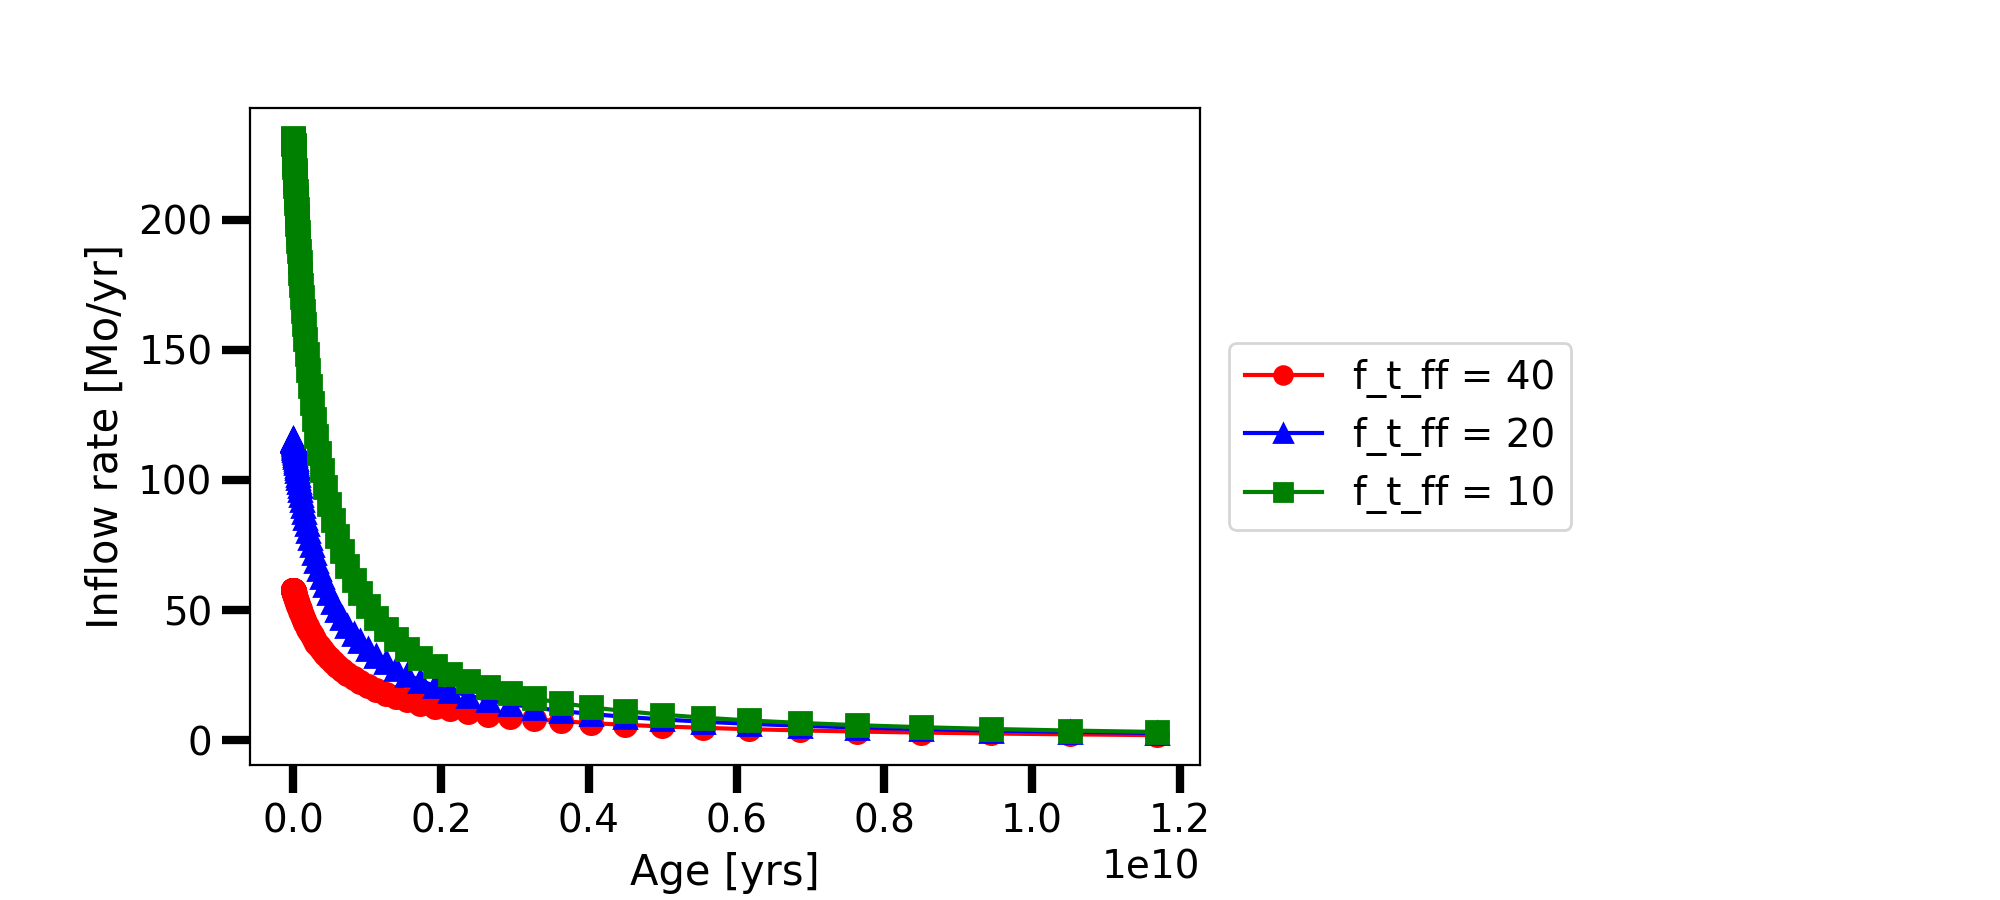

In [11]:
# Plot the inflow history
%matplotlib nbagg
op3_40.inner.plot_inflow_rate(color='r', marker="o", label='f_t_ff = 40')
op3_20.inner.plot_inflow_rate(color='b', marker="^", label='f_t_ff = 20')
op3_10.inner.plot_inflow_rate(color='g', marker="s", label='f_t_ff = 10')

<IPython.core.display.Javascript object>


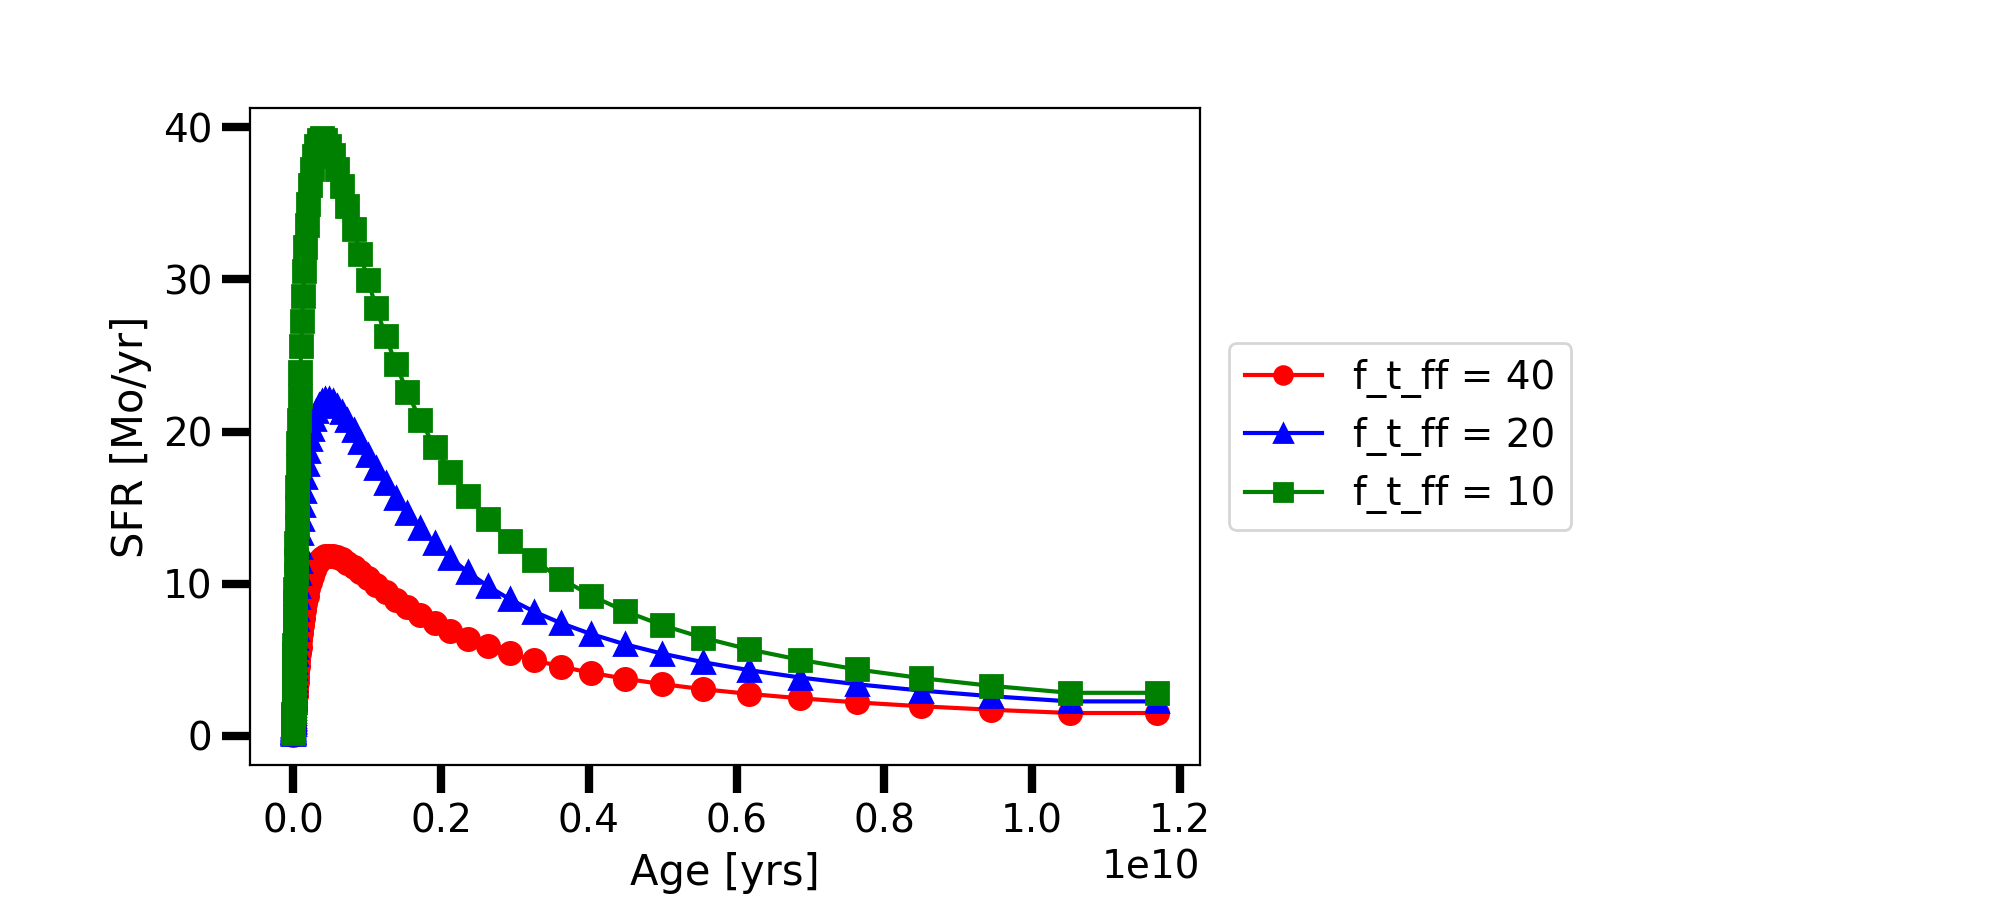

In [12]:
# Plot the star formation history
%matplotlib nbagg
op3_40.inner.plot_star_formation_rate(color='r', marker="o", label='f_t_ff = 40')
op3_20.inner.plot_star_formation_rate(color='b', marker="^", label='f_t_ff = 20')
op3_10.inner.plot_star_formation_rate(color='g', marker="s", label='f_t_ff = 10')

<IPython.core.display.Javascript object>


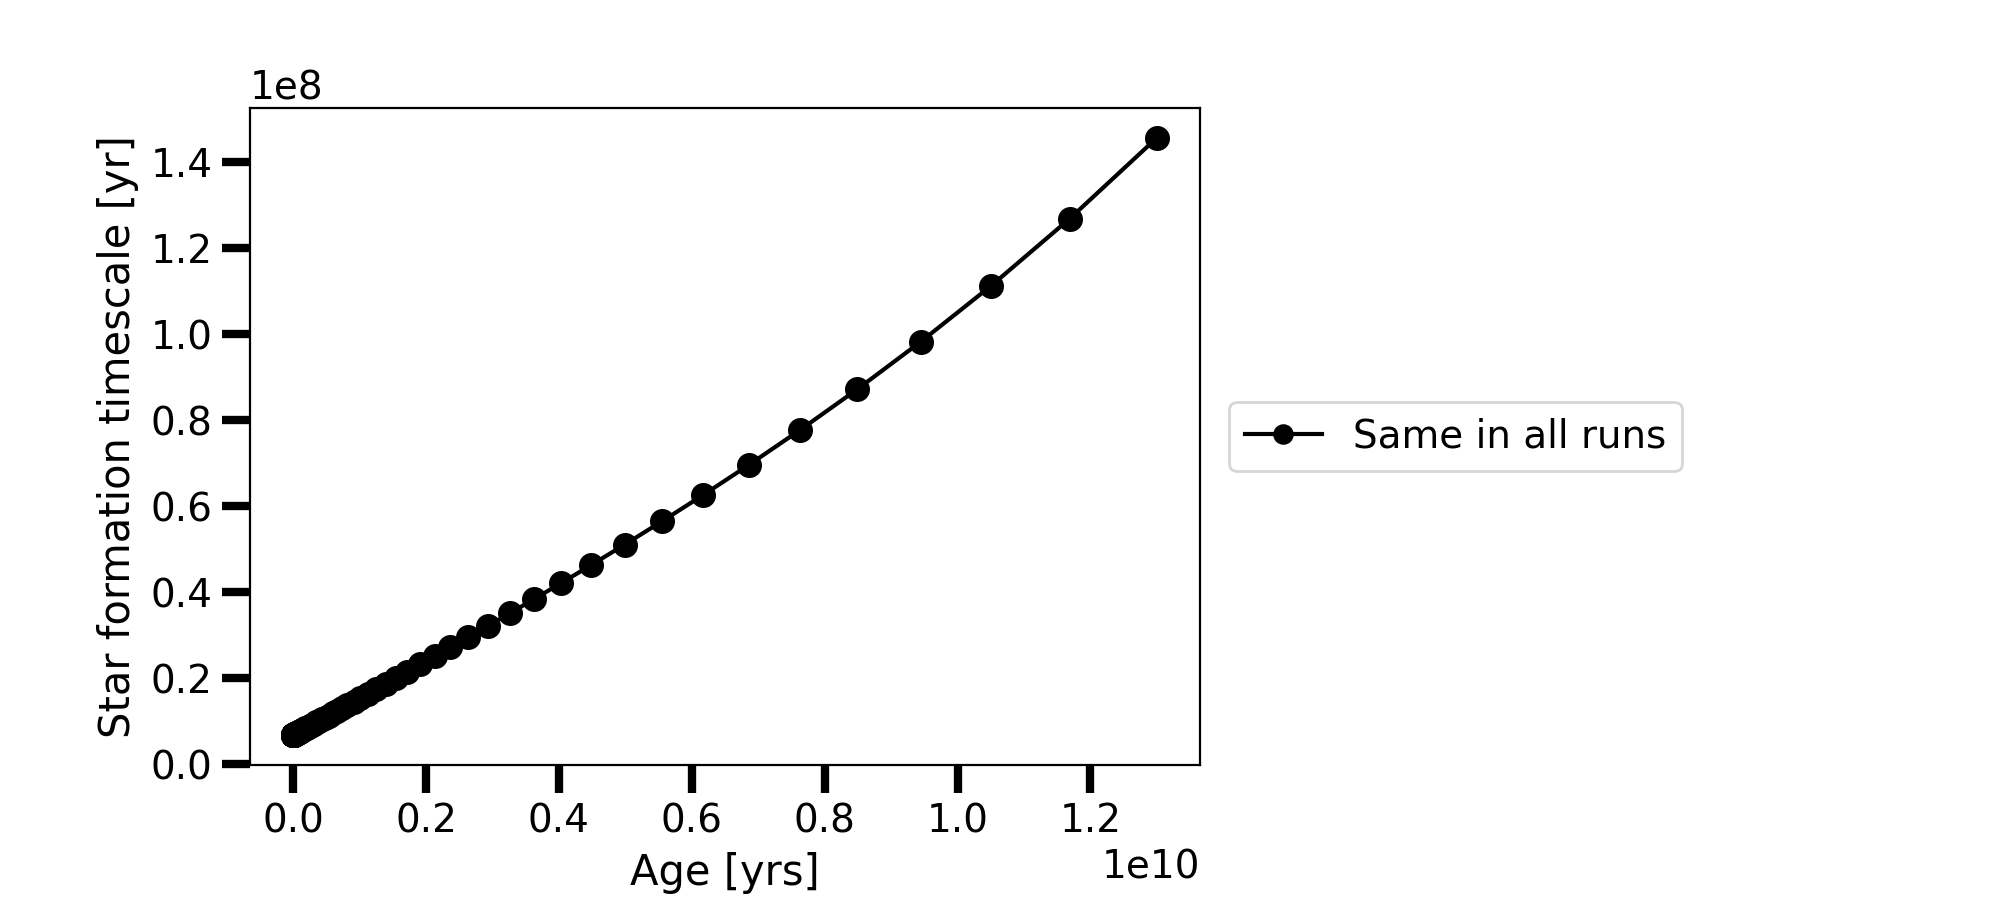

<IPython.core.display.Javascript object>


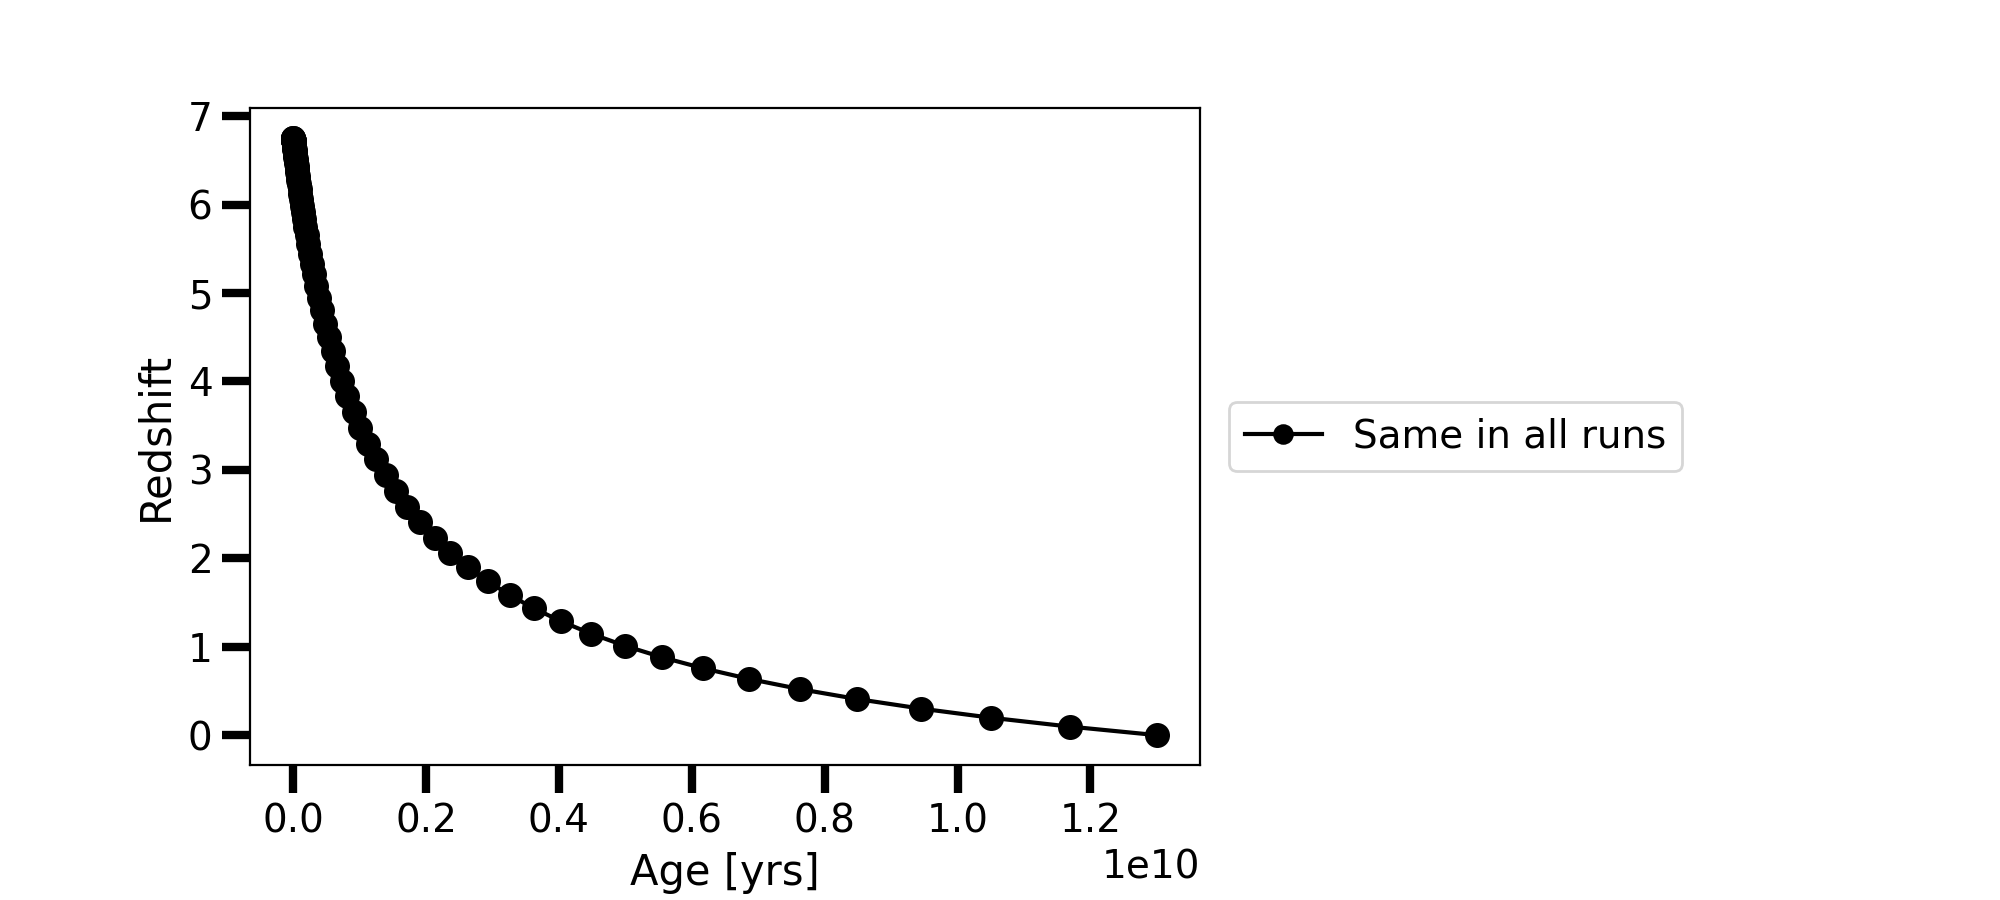

In [13]:
%matplotlib nbagg
op3_40.inner.plot_sf_timescale(color='k', label='Same in all runs')
op3_40.inner.plot_redshift(color='k', label='Same in all runs')

## 4. Input Inflow Array

This option allows to input an arbitrary inflow history using the *m_inflow_in* array.  Each index of the array contains the total mass of gas that is inflowing into the galaxy during a specific timestep.  This is not the inflow rate, but rather the  integrated inflow mass within a timestep.

**Important warning**: The timesteps are not necessarily constant in the code.  Please see our <a href="https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb">timestep size management</a> options.

In [14]:
# The length of the input array must be equal to the number of timestep
# Define constant timesteps for simplicity
nb_dt = 100              # Nb of timesteps
tend = 10.0e9            # Simulation ending time [yr]
special_timesteps = -1   # Cancel the logarithmic timestep option
dt = tend / float(nb_dt) # Duration of each timestep [yr]

# Set the common arguments for the upcoming OMEGA+ runs
kwargs_4 = {"mgal":mgal, "m_DM_0":m_DM_0, "sfe":sfe,
            "special_timesteps":special_timesteps, "tend":tend, "dt":dt}

In [15]:
# Define the maximum inflow rate for the random inflow history
max_inflow_rate = 10.0 # [Msun/yr]
max_inflow_in_dt = max_inflow_rate * dt

In [16]:
# Run OMEGA+ with a random inflow history
m_inflow_in_1 = np.zeros(nb_dt)
for i_dt in range(nb_dt):
    m_inflow_in_1[i_dt] = max_inflow_in_dt * np.random.rand()
op4_rdm1 = omega_plus.omega_plus(m_inflow_in=m_inflow_in_1, **kwargs_4)

# Run OMEGA+ with another random inflow history
m_inflow_in_2 = np.zeros(nb_dt)
for i_dt in range(nb_dt):
    m_inflow_in_2[i_dt] = max_inflow_in_dt * np.random.rand()
op4_rdm2 = omega_plus.omega_plus(m_inflow_in=m_inflow_in_2, **kwargs_4)

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.7s
   OMEGA+ run completed - Run time: 1.7s
OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.66s
   OMEGA+ run completed - Run time: 1.66s


<IPython.core.display.Javascript object>


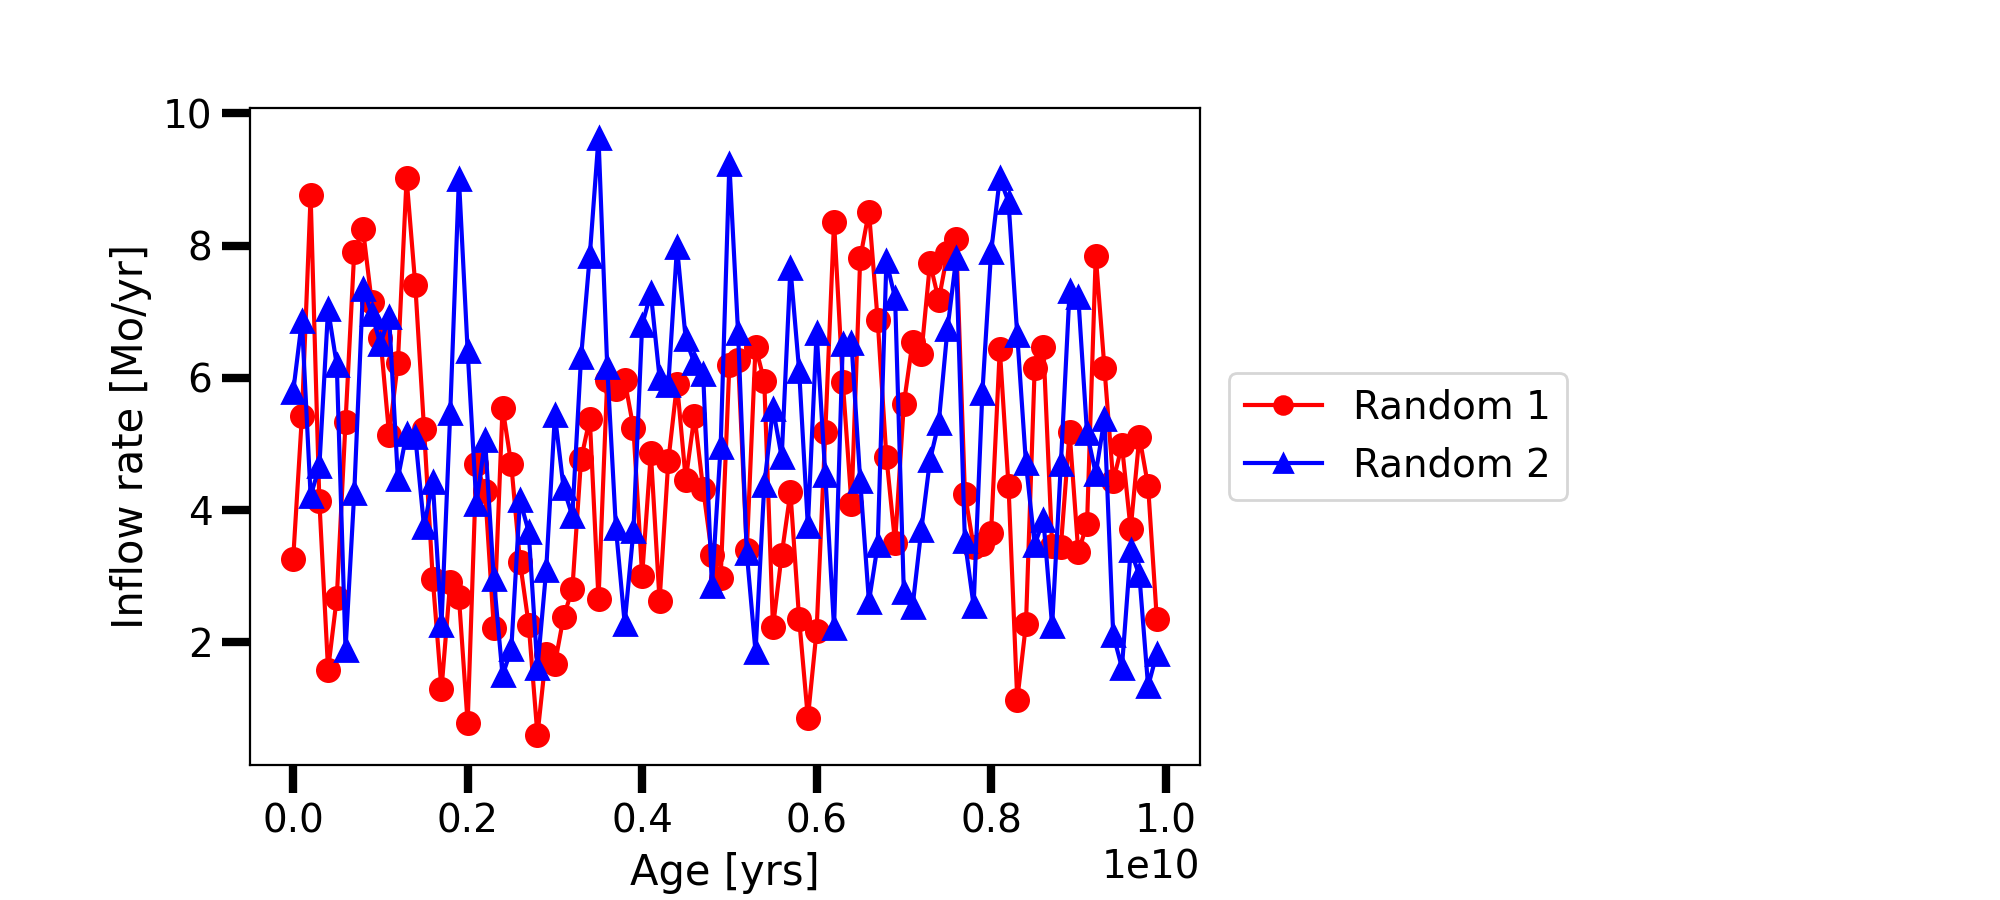

In [17]:
# Plot the inflow history
%matplotlib nbagg
op4_rdm1.inner.plot_inflow_rate(color='r', marker="o", label='Random 1')
op4_rdm2.inner.plot_inflow_rate(color='b', marker="^", label='Random 2')

<IPython.core.display.Javascript object>


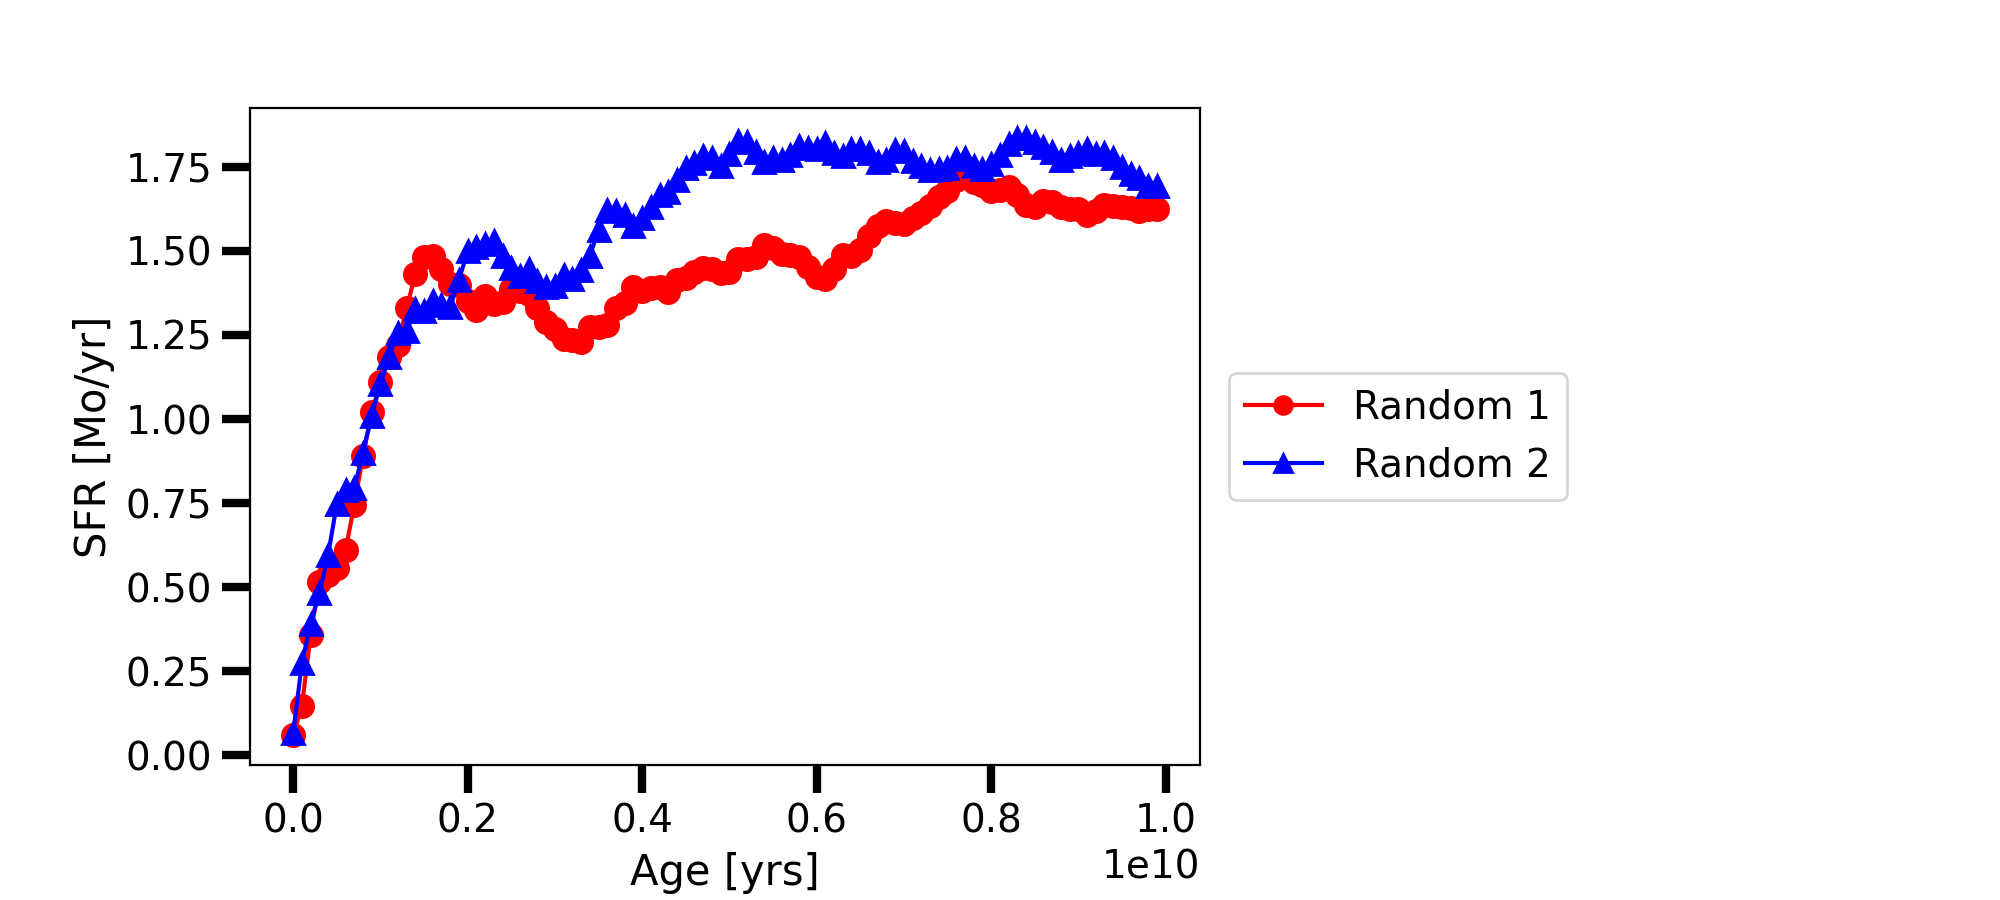

In [18]:
# Plot the star formation history
%matplotlib nbagg
op4_rdm1.inner.plot_star_formation_rate(color='r',  marker="o", label='Random 1')
op4_rdm2.inner.plot_star_formation_rate(color='b',  marker="^", label='Random 2')